# training and evaluating the CPA

In [1]:
import sys
sys.path.append('..')

import wandb
wandb.login()

from data import DataModule
from model import ComPert
import torch
import numpy as np
import time
import yaml
import lightning as L
from lightning.pytorch import seed_everything
from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: manuelgander1 (i_selbr). Use `wandb login --relogin` to force relogin


In [2]:
with open('config_hparam_test.yaml') as file:
    config_data = yaml.safe_load(file)

#seed_everything()

dm = DataModule(config_data['model']['hparams']['batch_size'],
                        config_data['model']['training_hparams']['full_eval_during_train'],
                        **config_data['dataset']['data_params'])
print(len(dm.datasets['training']))
print(len(dm.datasets['training_control']))
print(len(dm.datasets['training_treated']))
print(len(dm.datasets['test']))
print(len(dm.datasets['test_control']))
print(len(dm.datasets['test_treated']))
print(len(dm.datasets['ood']))
print(dm.datasets['training'].num_covariates)
print(dm.datasets['training'].num_drugs)
print(dm.datasets['training'].num_knockouts)

75503
10072
65431
13324
1763
11561
22428
[1]
0
106


## initialize the model

In [3]:
# initialize the model
# the knockouts embeddings are initialized as random 
model = ComPert(
    dm.datasets['training'].num_genes,
    dm.datasets['training'].num_drugs,
    dm.datasets['training'].num_knockouts,
    dm.datasets['training'].num_covariates,
    config_data['model']['hparams'],
    config_data['model']['training_hparams'],
    config_data['model']['test_hparams'],
    **config_data['model']['additional_params'],
    drug_embedding_dimension=dm.datasets['training'].drug_embedding_dimension,
    knockout_embedding_dimension=dm.datasets['training'].knockout_embedding_dimension)

## Initialize the trainer

In [4]:
early_stop_callback = EarlyStopping('average_r2_score', 
                                    patience=model.hparams.training_hparams['patience'], 
                                    mode='max')

if (not model.hparams.training_hparams['run_eval_disentangle']) and (not model.hparams.test_hparams['run_eval_disentangle']):
    trainer = L.Trainer(
        logger=WandbLogger(log_model="all"),
        max_epochs=config_data['model']['training_hparams']['num_epochs'],
        max_time=config_data['model']['training_hparams']['max_time'],
        check_val_every_n_epoch= config_data['model']['training_hparams']['checkpoint_freq'],
        default_root_dir=config_data['model']['training_hparams']['save_dir'],
        profiler="advanced",
        callbacks=[early_stop_callback],
        #inference_mode=False
    )
else: 
    trainer = L.Trainer(
        logger=WandbLogger(log_model="all"),
        max_epochs=config_data['model']['training_hparams']['num_epochs'],
        max_time=config_data['model']['training_hparams']['max_time'],
        check_val_every_n_epoch= config_data['model']['training_hparams']['checkpoint_freq'],
        default_root_dir=config_data['model']['training_hparams']['save_dir'],
        profiler="advanced",
        callbacks=[early_stop_callback],
        inference_mode=False
    )

/home/manu/miniconda3/envs/g/lib/python3.10/site-packages/lightning/fabric/accelerators/cuda.py:239: Can't initialize NVML
/home/manu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## train the model

In [5]:
trainer.fit(model, datamodule=dm)


  | Name                       | Type               | Params
------------------------------------------------------------------
0 | loss_autoencoder           | GaussianNLLLoss    | 0     
1 | encoder                    | MLP                | 1.9 M 
2 | decoder                    | MLP                | 2.9 M 
3 | knockout_embedding_encoder | MLP                | 1.9 M 
4 | knockout_effects           | GeneralizedSigmoid | 0     
5 | adversary_knockouts        | MLP                | 64.0 K
6 | loss_adversary_knockout    | CELoss             | 0     
------------------------------------------------------------------
6.8 M     Trainable params
0         Non-trainable params
6.8 M     Total params
27.046    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/manu/miniconda3/envs/g/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


0 combinations had '-inf' R2 scores:
	 set()


/home/manu/miniconda3/envs/g/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
/home/manu/miniconda3/envs/g/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.
FIT Profiler Report
Profile stats for: [LightningModule]ComPert.configure_callbacks
         7 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 contextlib.py:139(__exit__)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.next}
        1    0.000    0.000    0.000    0.000 profiler.py:54(profile)
        1    0.000    0.000    0.000    0.000 advanced.py:67(stop)
        1    0.000    0.000    0.000    0.000 module.py:899(configure_callbacks)
        1    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}



Profile stats for: [LightningDataModule]DataModule.prepare_data
         7 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumt

## test the model

In [6]:
results=trainer.test(model, datamodule=dm)[0]

/home/manu/miniconda3/envs/g/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Testing: 0it [00:00, ?it/s]

0 combinations had '-inf' R2 scores:
	 set()
0 combinations had '-inf' R2 scores:
	 set()
0 combinations had '-inf' R2 scores:
	 set()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric          ┃         DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       average_r2_score        │      0.7226853011079797       │
│       ood_logfold_score       │     -0.09681807593865828      │
│    ood_logfold_signs_score    │      0.5936363610354337       │
│        ood_mean_score         │      0.9851357476277784       │
│       ood_mean_score_de       │      0.8794277066534216       │
│       ood_sc_mean_score       │      0.8555602295832201       │
│     ood_sc_mean_score_de      │      0.7504917464473031       │
│       ood_sc_var_score        │      0.8207904154604132       │
│      ood_sc_var_score_de      │     -0.32995620369911194      │
│         ood_var_score         │      0.8127270611849698       │
│       ood_var_score_de        │      0.1872292377732017       │
│     optimal_disent_cov_0      │              1.0              │
│ optimal_disent_score_knockout │      0.13231762233563493      │
│      stats_disent_cov_0       │              1.0              │
│     stats_disent_knockout     │      0.16856800019741058      │
│      test_logfold_score       │      -3.5523383410323954      │
│   test_logfold_signs_score    │      0.6445070426788688       │
│        test_mean_score        │      0.9690368525299108       │
│      test_mean_score_de       │      0.8448587434952248       │
│      test_sc_mean_score       │      0.8327541723497597       │
│     test_sc_mean_score_de     │       0.746361136174118       │
│       test_sc_var_score       │       0.791158377284735       │
│     test_sc_var_score_de      │      0.1592337256865882       │
│        test_var_score         │      0.7527099484009362       │
│       test_var_score_de       │      0.32413566000584704      │
│    training_logfold_score     │      -4.329861104766899       │
│ training_logfold_signs_score  │      0.6548598135743185       │
│      training_mean_score      │      0.9725230093871322       │
│    training_mean_score_de     │      0.8415258705058944       │
│    training_sc_mean_score     │      0.8308987330610507       │
│   training_sc_mean_score_de   │      0.7444699426817003       │
│     training_sc_var_score     │      0.8345297157207382       │
│   training_sc_var_score_de    │      0.16854923211525533      │
│      training_var_score       │      0.7917755686234091       │
│     training_var_score_de     │      0.34516489060125616      │
└───────────────────────────────┴───────────────────────────────┘

TEST Profiler Report
Profile stats for: [LightningModule]ComPert.configure_callbacks
         7 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 contextlib.py:139(__exit__)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.next}
        1    0.000    0.000    0.000    0.000 profiler.py:54(profile)
        1    0.000    0.000    0.000    0.000 advanced.py:67(stop)
        1    0.000    0.000    0.000    0.000 module.py:899(configure_callbacks)
        1    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}



Profile stats for: [LightningDataModule]DataModule.prepare_data
         7 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        

In [7]:
results

{'stats_disent_knockout': 0.16856800019741058,
 'optimal_disent_score_knockout': 0.13231762233563493,
 'stats_disent_cov_0': 1.0,
 'optimal_disent_cov_0': 1.0,
 'training_mean_score': 0.9725230093871322,
 'training_mean_score_de': 0.8415258705058944,
 'training_var_score': 0.7917755686234091,
 'training_var_score_de': 0.34516489060125616,
 'test_mean_score': 0.9690368525299108,
 'test_mean_score_de': 0.8448587434952248,
 'test_var_score': 0.7527099484009362,
 'test_var_score_de': 0.32413566000584704,
 'ood_mean_score': 0.9851357476277784,
 'ood_mean_score_de': 0.8794277066534216,
 'ood_var_score': 0.8127270611849698,
 'ood_var_score_de': 0.1872292377732017,
 'training_sc_mean_score': 0.8308987330610507,
 'training_sc_mean_score_de': 0.7444699426817003,
 'training_sc_var_score': 0.8345297157207382,
 'training_sc_var_score_de': 0.16854923211525533,
 'test_sc_mean_score': 0.8327541723497597,
 'test_sc_mean_score_de': 0.746361136174118,
 'test_sc_var_score': 0.791158377284735,
 'test_sc_va

In [ ]:
# relatively ok r2 scores

## Get a prediction - this follows evaluate_logfold_r2 as closely as possible

In [8]:
from train import compute_prediction, set_up_covariates, bool2idx
import pandas as pd

In [9]:
ds_treated = dm.datasets['ood']
ds_ctrl = dm.datasets['training_control']

treated_pert_cat_index = pd.Index(ds_treated.pert_categories, dtype="category")
cov_type = ds_treated.covariate_keys[0]

In [11]:
cell_pert_comb='K562_CEBPE'
covariate = cell_pert_comb.split("_")[0]

In [12]:
bool_pert_categoy = treated_pert_cat_index.get_loc(cell_pert_comb)
idx_treated_all = bool2idx(bool_pert_categoy)
idx_treated = idx_treated_all[0]

In [13]:
bool_ctrl_all = ds_ctrl.covariate_names[cov_type] == covariate
idx_ctrl_all = bool2idx(bool_ctrl_all)
n_idx_ctrl = len(idx_ctrl_all)

In [14]:
genes_ctrl = ds_ctrl.genes[idx_ctrl_all]

In [15]:
covs, drugs, knockouts = set_up_covariates(ds_treated, idx_treated, n_idx_ctrl)

In [16]:
genes_pred, _ = compute_prediction(trainer.model, genes_ctrl, drugs=drugs, knockouts=knockouts, covs=covs)

### Combine it in an anndata

In [17]:
import anndata
# training data
a0=anndata.AnnData(dm.datasets['training'].genes.detach().numpy())
a0.obs['set']='training'
a0.obs['treatment']=dm.datasets['training'].knockouts_names


# perturbation data - measurment
a1=anndata.AnnData(dm.datasets['ood'].genes.detach().numpy())
a1.obs['set']='pertubed_real'
a1.obs['treatment']=dm.datasets['ood'].knockouts_names
a1=a1[a1.obs['treatment']==cell_pert_comb.split('_')[1]].copy()

# perturbation data - measurment
a2=anndata.AnnData(genes_pred.numpy())
a2.obs['set']='pertubed_predicted'
a2.obs['treatment']=cell_pert_comb.split('_')[1]

In [18]:
adata=anndata.concat([a0,a1,a2])
adata

/home/manu/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 86805 × 2000
    obs: 'set', 'treatment'

In [19]:
Path='/home/manu/chemCPA/chemCPA/anndatas'
adata.write(f'{Path}/adata_pred.h5ad')

In [20]:
# Save and reload

In [1]:
import scanpy as sc
import numpy as np
import torch
from torchmetrics import R2Score
Path='/home/manu/chemCPA/chemCPA/anndatas'
adata=sc.read_h5ad(f'{Path}/adata_pred.h5ad')
adata.obs['reduced_treatments']=[a if a in ['control', 'CEBPE'] else 'not' for a in adata.obs['treatment']]

/home/manu/bl/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### And some UMAPS

In [2]:
sc.pp.pca(adata)

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


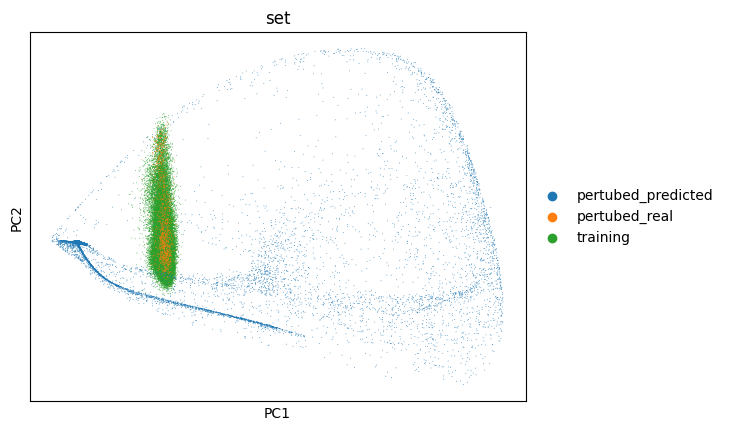

In [3]:
sc.pl.pca(adata, color='set')

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


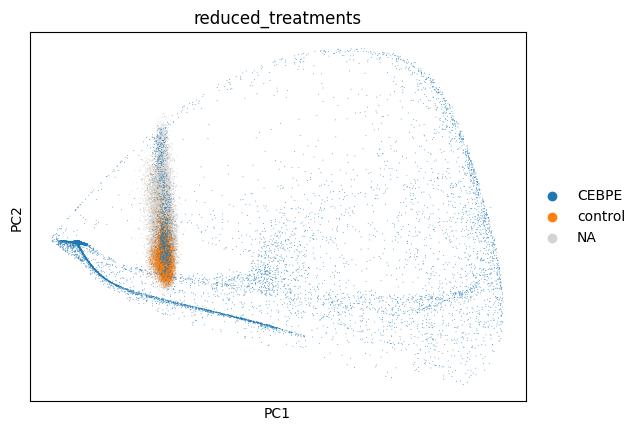

In [6]:
sc.pl.pca(adata, color='reduced_treatments', groups=['control', 'CEBPE'])

In [7]:
sc.pp.neighbors(adata)

/home/manu/bl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
sc.tl.umap(adata, random_state=0)

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


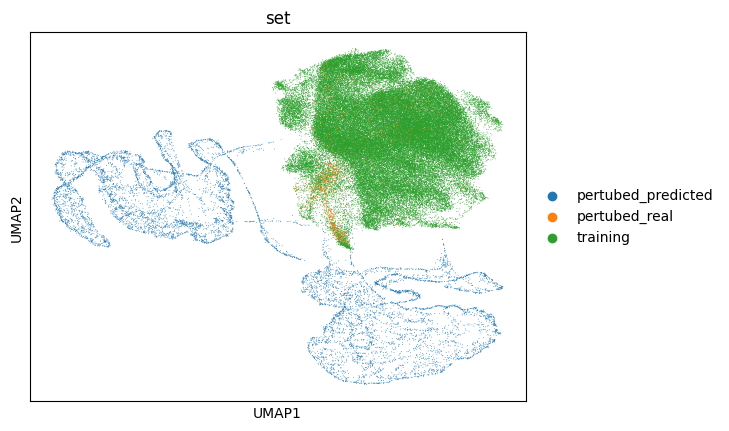

In [9]:
sc.pl.umap(adata, color='set')

In [19]:
adata.obs['set_and_treatment']=adata.obs['set'].astype('str')+'_'+adata.obs['reduced_treatments'].astype('str')
adata.obs['set_and_treatment'].value_counts()

set_and_treatment
training_not                65431
training_control            10072
pertubed_predicted_CEBPE    10072
pertubed_real_CEBPE          1230
Name: count, dtype: int64

/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/manu/bl/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


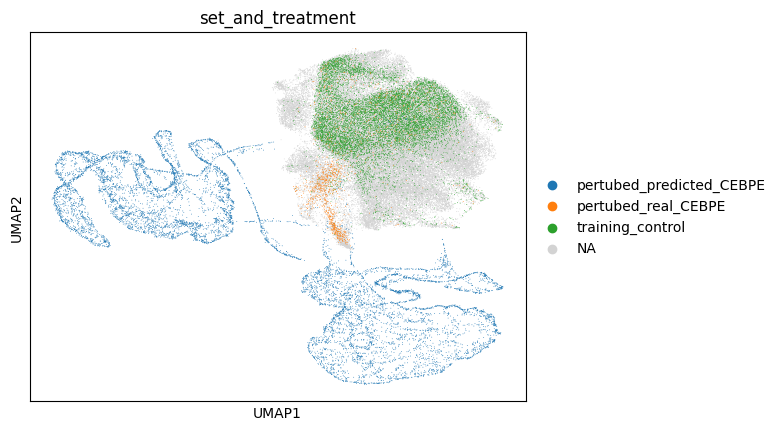

In [21]:
sc.pl.umap(adata, color='set_and_treatment', groups=['training_control', 'pertubed_predicted_CEBPE', 'pertubed_real_CEBPE'])

### And calcualte r2

In [22]:
def compute_r2(y_true, y_pred):
    """
    Computes the r2 score for `y_true` and `y_pred`,
    returns `-1` when `y_pred` contains nan values
    """
    y_pred = torch.clamp(y_pred, -3e12, 3e12)
    metric = R2Score().to(y_true.device)
    metric.update(y_pred, y_true)  # same as sklearn.r2_score(y_true, y_pred)
    return metric.compute().item()

In [23]:
adata.obs.set.value_counts()

set
training              75503
pertubed_predicted    10072
pertubed_real          1230
Name: count, dtype: int64

In [24]:
mean_pred=adata[adata.obs['set']=='pertubed_predicted'].X
yp_m = mean_pred.mean(0)

In [25]:
treatment=adata[adata.obs['set']=='pertubed_predicted'].obs['treatment'].iloc[0]
y_true = adata[(adata.obs['set']=='pertubed_real')&(adata.obs['treatment']==treatment)].X
yt_m = np.nanmean(y_true, 0)

In [26]:
compute_r2(torch.tensor(yt_m), torch.tensor(yp_m))

0.8032898306846619

In [ ]:
# Pretty decent r2 scores but predictions are really bad when one considers the UMAP